<a href="https://colab.research.google.com/github/GLEYSONRN/mastersdegree/blob/main/CPTEn_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas e arquivos necessários

In [ ]:
!gdown 15DVijHpRZxtyQuwTwqjlmU06LUBnWOFt
!gdown 1qEliqPLoJ4KSKu6EQ_HYardC_Jn34Vb4
!7z e CSV_Files.zip
!rm CSV_Files.zip
!gdown 1KWp0CA8POz9cEwUREjUO7z5kZDVnNWzM
!gdown 1lNjkhDM4c5f2ViMcE8wAdOuocL--nHoO

'\n!gdown 15DVijHpRZxtyQuwTwqjlmU06LUBnWOFt #importando dados UNISOLAR (benchmark geracao)\n!gdown 1qEliqPLoJ4KSKu6EQ_HYardC_Jn34Vb4 #importando dados GPVS-Faults (benchmark falhas)\n#!7z e CSV_Files.zip #descompactando os dados do GPVS\n#!rm CSV_Files.zip #deletando arquivo zip\n!gdown 1KWp0CA8POz9cEwUREjUO7z5kZDVnNWzM #importando dados do Ginásio Muldisciplinar - imputado\n!gdown 1lNjkhDM4c5f2ViMcE8wAdOuocL--nHoO\n'

In [ ]:
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import tensorflow as tf
import random
import os
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [ ]:
tf.config.experimental.enable_tensor_float_32_execution(False)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
tf.keras.backend.set_floatx('float32')

In [ ]:
from tensorflow.keras.backend import clear_session
from keras import backend as K

clear_session()
K.clear_session()
gc.collect()

104

In [ ]:
SEED = 123
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
sns.set(rc={
    'axes.axisbelow': False,
    'axes.edgecolor': 'lightgrey',
    'axes.facecolor': 'None',
    'axes.grid': False,
    'axes.labelcolor': 'black',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.facecolor': 'w',
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'text.color': 'black',
    'xtick.bottom': True,
    'xtick.color': 'black',
    'xtick.direction': 'out',
    'xtick.top': False,
    'ytick.color': 'black',
    'ytick.direction': 'out',
    'ytick.left': True,
    'ytick.right': False})

'''
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":24,
                                "axes.labelsize":18})
'''

'\nsns.set_context("notebook", rc={"font.size":20,\n                                "axes.titlesize":24,\n                                "axes.labelsize":18})\n'

# Dados Ginásio Multidisciplinar - CPTEn

In [ ]:
df_ginasio = pd.read_csv('ginasio_clima.csv')

In [ ]:
df_ginasio.head()

,Vac1,Vac2,Vac3,Iac1,Iac2,Iac3,Freq,Pac(W),Qac,CosPhi,Vdc1,Idc1,Pdc1,PacGrid,Energy(kWh),ALLSKY_SFC_SW_DWN,ALLSKY_SFC_PAR_TOT,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB,ALLSKY_SFC_UV_INDEX,T2M,T2MDEW,RH2M,PRECTOTCORR,PS,WS10M,WD10M,T2MWET,QV2M,SerialNumber,BoardId,DateTime,GId
0,132.32,132.17,132.41,0.00,0.00,0.00,60.00,0.00,1.57,0.00,580.06,0.00,0.00,0.0,0.00,418.829907,188.831701,24.565894,0.700218,3.635497,24.309817,14.868542,65.829386,0.127613,92.859952,2.833711,205.173799,19.589086,11.787670,380118281416,1DM182813A58,2019-05-04 06:15:00,GINASIO / INVERSOR E
1,132.38,132.21,132.44,1.67,1.59,1.58,60.01,278.89,8.23,-0.02,646.85,0.45,283.97,0.0,0.07,418.149708,188.999570,24.563224,0.700082,3.628132,24.309935,14.868569,64.349319,0.152956,92.890246,2.991591,206.737297,19.589102,11.800590,380118281416,1DM182813A58,2019-05-04 06:30:00,GINASIO / INVERSOR E
2,132.27,132.08,132.24,4.57,4.39,4.56,60.01,1544.97,-0.09,-0.10,739.92,2.14,1587.40,0.0,0.46,413.144859,188.885958,24.711878,0.693977,3.612792,24.309891,14.868609,62.415360,0.175646,92.902015,3.328589,203.934324,19.589131,11.750556,380118281416,1DM182813A58,2019-05-04 06:45:00,GINASIO / INVERSOR E
3,131.93,131.76,131.89,7.90,7.67,7.97,59.99,2977.64,-0.19,0.02,759.57,4.03,3065.23,0.0,1.20,102.020000,44.900000,5.660000,0.030000,0.170000,21.000000,18.290000,84.310000,0.000000,93.220000,2.650000,52.560000,19.650000,14.100000,380118281416,1DM182813A58,2019-05-04 07:00:00,GINASIO / INVERSOR E
4,131.36,131.20,131.33,12.21,11.83,12.24,59.98,4672.84,-0.19,-0.03,770.24,6.24,4812.42,0.0,2.37,409.506854,188.799377,24.844197,0.690942,3.602437,24.309907,14.868629,61.223000,0.171809,92.935683,3.539572,204.551411,19.589140,11.726195,380118281416,1DM182813A58,2019-05-04 07:15:00,GINASIO / INVERSOR E


In [ ]:
subset_E = df_ginasio[(df_ginasio.GId == 'GINASIO / INVERSOR E')
                      & (df_ginasio.Freq >= 59)]
subset_E.columns

Index(['Vac1', 'Vac2', 'Vac3', 'Iac1', 'Iac2', 'Iac3', 'Freq', 'Pac(W)', 'Qac',
       'CosPhi', 'Vdc1', 'Idc1', 'Pdc1', 'PacGrid', 'Energy(kWh)',
       'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA',
       'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UV_INDEX', 'T2M', 'T2MDEW', 'RH2M',
       'PRECTOTCORR', 'PS', 'WS10M', 'WD10M', 'T2MWET', 'QV2M', 'SerialNumber',
       'BoardId', 'DateTime', 'GId'],
      dtype='object')

In [ ]:
subset_E = subset_E.drop(columns=['SerialNumber', 'BoardId', 'GId', 'PacGrid'])

In [ ]:
subset_E['DateTime'] = pd.to_datetime(subset_E['DateTime'])
subset_E.rename(columns={'DateTime': 'ds', 'Energy(kWh)': 'y'}, inplace=True)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

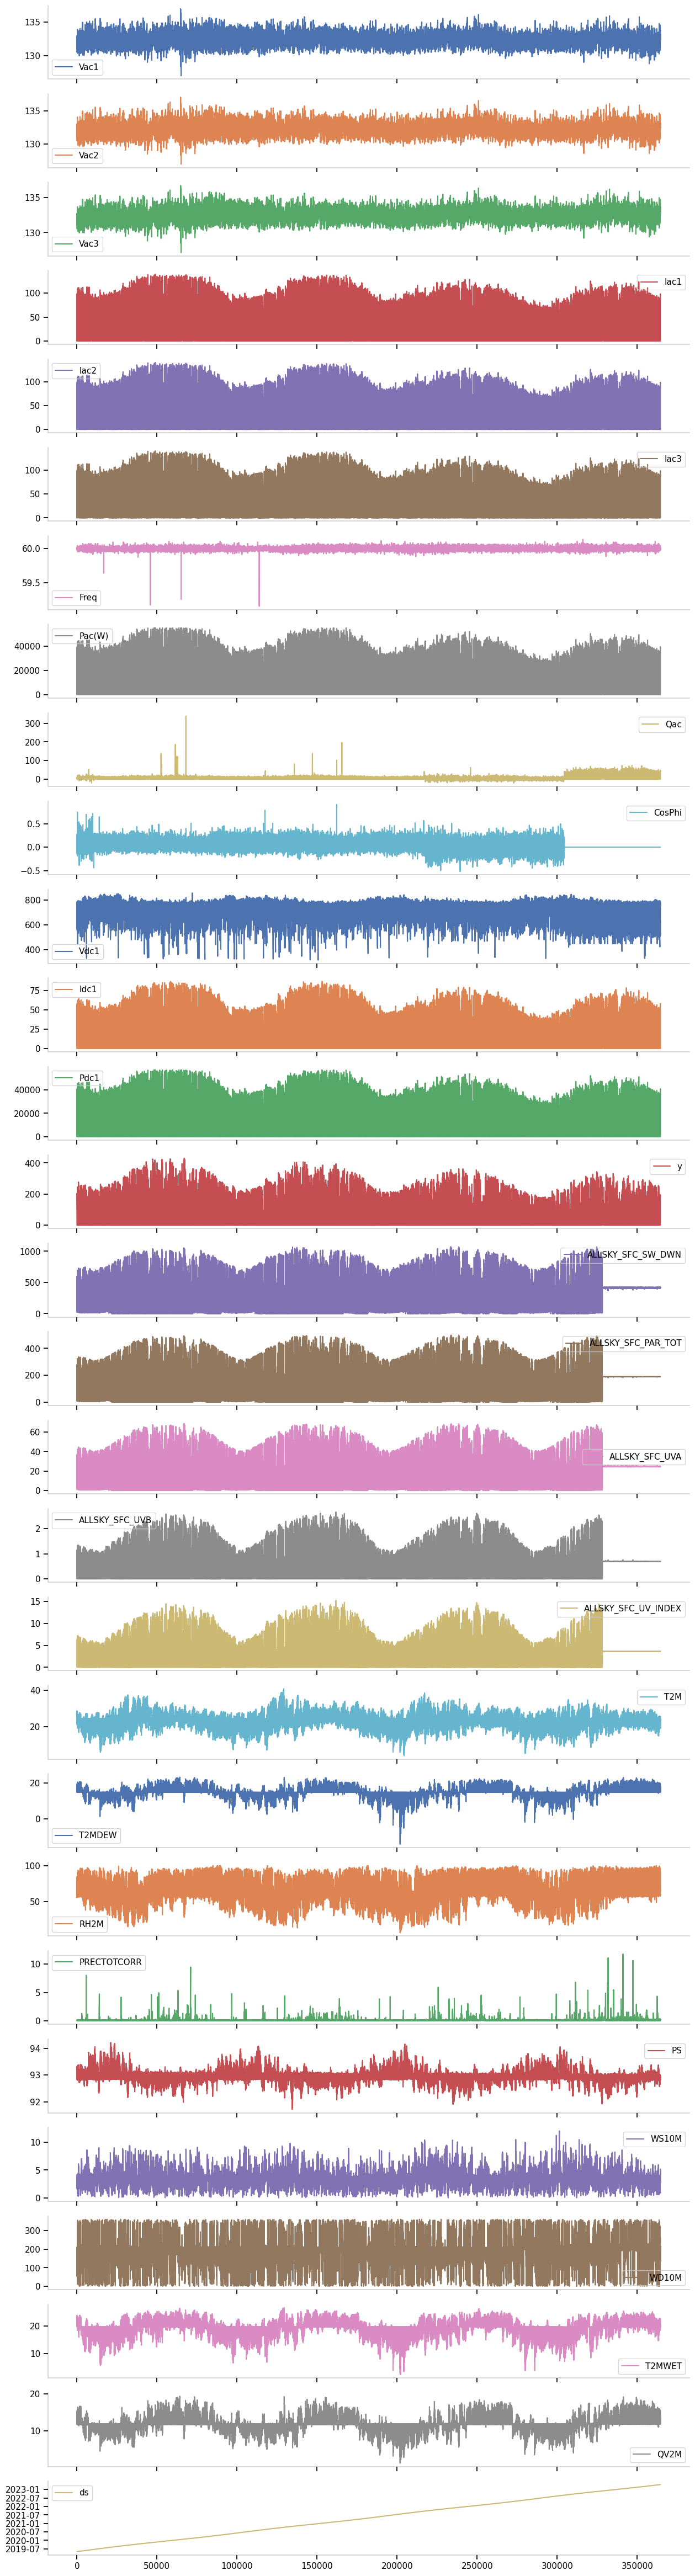

In [ ]:
subset_E.plot(subplots=True, figsize=(15, 60))

In [ ]:
subset_E = subset_E.set_index('ds')
subset_E = subset_E.resample('D').mean()
subset_E = subset_E.fillna(method='ffill')
subset_E = subset_E.reset_index()

<ipython-input-14-7ee48d526e23>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  subset_E = subset_E.fillna(method='ffill')


In [ ]:
subset_E = subset_E[['Vac1', 'Vac2', 'Vac3', 'Iac1', 'Iac2', 'Iac3', 'Freq', 'Pac(W)', 'Qac',
                     'CosPhi', 'Vdc1', 'Idc1', 'Pdc1', 'ALLSKY_SFC_SW_DWN',
                     'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SFC_UVA', 'ALLSKY_SFC_UVB',
                     'ALLSKY_SFC_UV_INDEX', 'T2M', 'T2MDEW', 'RH2M', 'PRECTOTCORR', 'PS',
                     'WS10M', 'WD10M', 'T2MWET', 'QV2M', 'ds', 'y']]

In [ ]:
subset_E.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Vac1                 1443 non-null   float64       
 1   Vac2                 1443 non-null   float64       
 2   Vac3                 1443 non-null   float64       
 3   Iac1                 1443 non-null   float64       
 4   Iac2                 1443 non-null   float64       
 5   Iac3                 1443 non-null   float64       
 6   Freq                 1443 non-null   float64       
 7   Pac(W)               1443 non-null   float64       
 8   Qac                  1443 non-null   float64       
 9   CosPhi               1443 non-null   float64       
 10  Vdc1                 1443 non-null   float64       
 11  Idc1                 1443 non-null   float64       
 12  Pdc1                 1443 non-null   float64       
 13  ALLSKY_SFC_SW_DWN    1443 non-nul

In [ ]:
colunas = subset_E.columns

In [ ]:
df_train = subset_E[:-430]
train = df_train[:-300]
val = df_train[-300:]
test = subset_E[-430:]

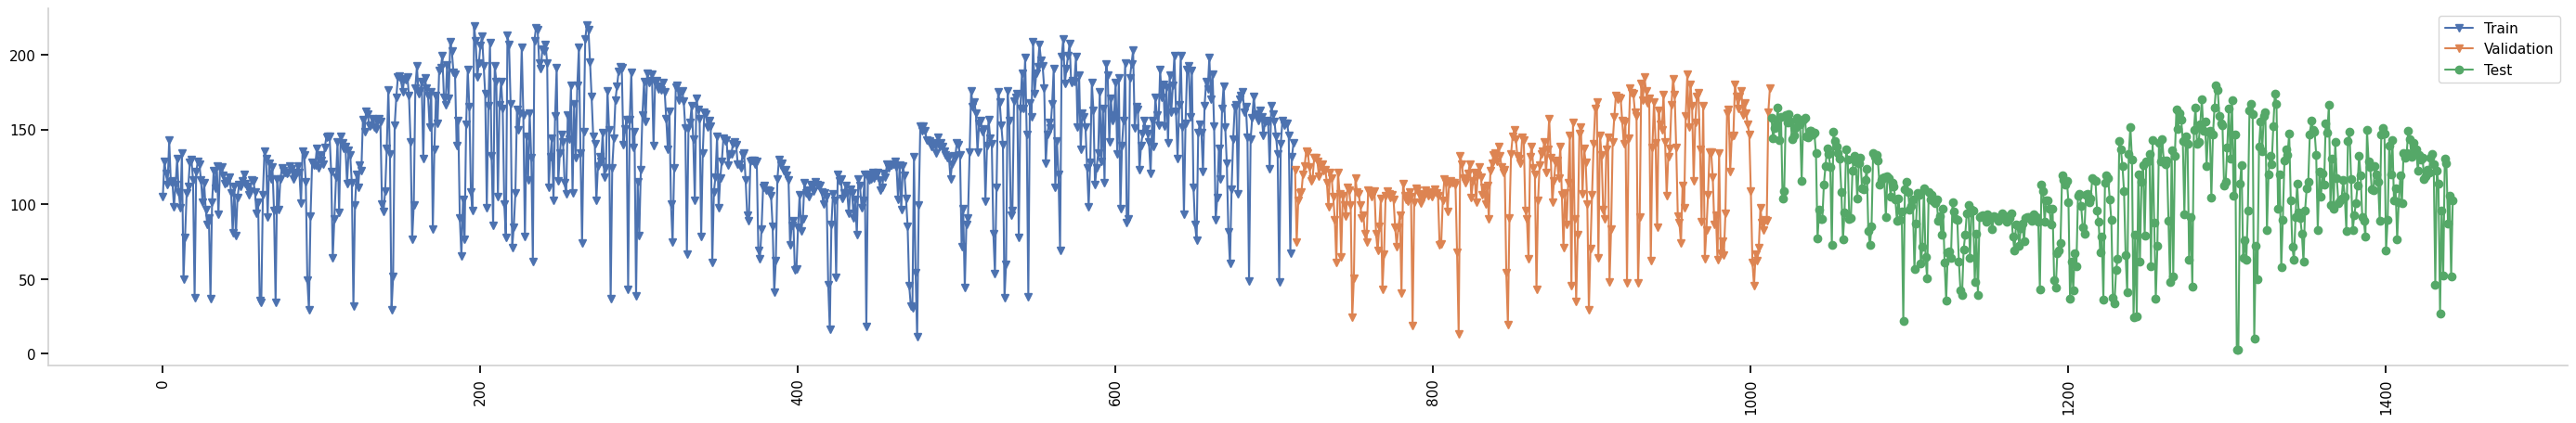

In [ ]:
plt.figure(figsize=(35, 5))
plt.plot(train['y'], marker='v', label='Train')
plt.plot(val['y'], marker='v', label='Validation')
plt.plot(test['y'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
train.drop(columns=['y', 'ds']).shape, val.drop(
    columns=['y', 'ds']).shape, test.drop(columns=['y', 'ds']).shape

((713, 27), (300, 27), (430, 27))

In [ ]:
x_train = train.drop(columns=['y', 'ds']).values.reshape(train.drop(
    columns=['y', 'ds']).shape[0], train.drop(columns=['y', 'ds']).shape[1], 1)
x_val = val.drop(columns=['y', 'ds']).values.reshape(val.drop(
    columns=['y', 'ds']).shape[0], val.drop(columns=['y', 'ds']).shape[1], 1)
x_test = test.drop(columns=['y', 'ds']).values.reshape(test.drop(
    columns=['y', 'ds']).shape[0], test.drop(columns=['y', 'ds']).shape[1], 1)
x_train.shape, x_val.shape, x_test.shape

((713, 27, 1), (300, 27, 1), (430, 27, 1))

In [ ]:
y_train = train['y'].values
y_val = val['y'].values
y_test = test['y'].values
y_train.shape, y_val.shape, y_test.shape

((713,), (300,), (430,))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (x_val, y_val)).batch(32).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(32).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
l2_reg = 0.01
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu',
           input_shape=(27, 1), kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Conv1D(filters=6, kernel_size=2, activation='relu',
           kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Flatten(),
    Dense(150, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.2),
    Dense(1, activation='linear', kernel_regularizer=l2(l2_reg))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 25, 64)            256       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 6)             774       
                                                                 
 batch_normalization_1 (Bat  (None, 24, 6)             24        
 chNormalization)                                                
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 150)               2

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="cnn.h5",
    monitor='val_loss',
    save_best_only=True,
)

In [ ]:
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=1e-2,
              rho=0.9, momentum=0.0, epsilon=1e-10), metrics=[RootMeanSquaredError()])

In [ ]:
history = model.fit(train_dataset, epochs=2000, validation_data=val_dataset,
                    shuffle=False, callbacks=model_checkpoint)

Epoch 1/2000
23/23 [==============================] - 2s 11ms/step - loss: 2066.6484 - root_mean_squared_error: 45.4383 - val_loss: 12862.6494 - val_root_mean_squared_error: 113.4045
Epoch 2/2000
23/23 [==============================] - 0s 4ms/step - loss: 572.0583 - root_mean_squared_error: 23.8743 - val_loss: 2876.9626 - val_root_mean_squared_error: 53.6182
Epoch 3/2000
23/23 [==============================] - 0s 3ms/step - loss: 471.2379 - root_mean_squared_error: 21.6621 - val_loss: 4131.5654 - val_root_mean_squared_error: 64.2623
Epoch 4/2000


/home/grnbatera/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 0s 4ms/step - loss: 533.5800 - root_mean_squared_error: 23.0565 - val_loss: 4498.4360 - val_root_mean_squared_error: 67.0559
Epoch 5/2000
23/23 [==============================] - 0s 4ms/step - loss: 414.7696 - root_mean_squared_error: 20.3193 - val_loss: 1139.0220 - val_root_mean_squared_error: 33.7223
Epoch 6/2000
23/23 [==============================] - 0s 3ms/step - loss: 411.4808 - root_mean_squared_error: 20.2405 - val_loss: 1183.1265 - val_root_mean_squared_error: 34.3703
Epoch 7/2000
23/23 [==============================] - 0s 4ms/step - loss: 442.6490 - root_mean_squared_error: 20.9948 - val_loss: 160.5499 - val_root_mean_squared_error: 12.5991
Epoch 8/2000
23/23 [==============================] - 0s 3ms/step - loss: 368.2342 - root_mean_squared_error: 19.1414 - val_loss: 15064.1670 - val_root_mean_squared_error: 122.7288
Epoch 9/2000
23/23 [==============================] - 0s 3ms/step - loss: 379.7555 - root_mean_squared_error: 19.4402

Epoch 50/2000
23/23 [==============================] - 0s 3ms/step - loss: 345.2920 - root_mean_squared_error: 18.5254 - val_loss: 297.4233 - val_root_mean_squared_error: 17.1838
Epoch 51/2000
23/23 [==============================] - 0s 3ms/step - loss: 377.9746 - root_mean_squared_error: 19.3869 - val_loss: 323.5287 - val_root_mean_squared_error: 17.9281
Epoch 52/2000
23/23 [==============================] - 0s 3ms/step - loss: 345.0675 - root_mean_squared_error: 18.5181 - val_loss: 310.7606 - val_root_mean_squared_error: 17.5683
Epoch 53/2000
23/23 [==============================] - 0s 3ms/step - loss: 354.5525 - root_mean_squared_error: 18.7728 - val_loss: 163.5663 - val_root_mean_squared_error: 12.7052
Epoch 54/2000
23/23 [==============================] - 0s 3ms/step - loss: 324.0192 - root_mean_squared_error: 17.9403 - val_loss: 222.1703 - val_root_mean_squared_error: 14.8328
Epoch 55/2000
23/23 [==============================] - 0s 4ms/step - loss: 336.8053 - root_mean_squared_e

Epoch 96/2000
23/23 [==============================] - 0s 3ms/step - loss: 353.3028 - root_mean_squared_error: 18.7145 - val_loss: 137.0620 - val_root_mean_squared_error: 11.5763
Epoch 97/2000
23/23 [==============================] - 0s 3ms/step - loss: 316.9637 - root_mean_squared_error: 17.7162 - val_loss: 176.1433 - val_root_mean_squared_error: 13.1545
Epoch 98/2000
23/23 [==============================] - 0s 3ms/step - loss: 357.5639 - root_mean_squared_error: 18.8264 - val_loss: 134.9263 - val_root_mean_squared_error: 11.4821
Epoch 99/2000
23/23 [==============================] - 0s 3ms/step - loss: 363.3222 - root_mean_squared_error: 18.9785 - val_loss: 131.5922 - val_root_mean_squared_error: 11.3339
Epoch 100/2000
23/23 [==============================] - 0s 3ms/step - loss: 315.2473 - root_mean_squared_error: 17.6660 - val_loss: 143.2844 - val_root_mean_squared_error: 11.8376
Epoch 101/2000
23/23 [==============================] - 0s 3ms/step - loss: 380.0370 - root_mean_squared

23/23 [==============================] - 0s 3ms/step - loss: 325.2624 - root_mean_squared_error: 17.8773 - val_loss: 195.8884 - val_root_mean_squared_error: 13.7940
Epoch 187/2000
23/23 [==============================] - 0s 3ms/step - loss: 354.5245 - root_mean_squared_error: 18.6774 - val_loss: 261.2012 - val_root_mean_squared_error: 15.9868
Epoch 188/2000
23/23 [==============================] - 0s 3ms/step - loss: 348.4262 - root_mean_squared_error: 18.5139 - val_loss: 139.8019 - val_root_mean_squared_error: 11.5795
Epoch 189/2000
23/23 [==============================] - 0s 3ms/step - loss: 350.7749 - root_mean_squared_error: 18.5751 - val_loss: 169.0661 - val_root_mean_squared_error: 12.7799
Epoch 190/2000
23/23 [==============================] - 0s 3ms/step - loss: 354.5139 - root_mean_squared_error: 18.6741 - val_loss: 150.4502 - val_root_mean_squared_error: 12.0278
Epoch 191/2000
23/23 [==============================] - 0s 3ms/step - loss: 353.0003 - root_mean_squared_error: 18.

23/23 [==============================] - 0s 3ms/step - loss: 313.4433 - root_mean_squared_error: 17.4589 - val_loss: 168.7298 - val_root_mean_squared_error: 12.6575
Epoch 277/2000
23/23 [==============================] - 0s 4ms/step - loss: 347.6820 - root_mean_squared_error: 18.4160 - val_loss: 155.5383 - val_root_mean_squared_error: 12.1252
Epoch 278/2000
23/23 [==============================] - 0s 3ms/step - loss: 322.6516 - root_mean_squared_error: 17.7232 - val_loss: 179.3555 - val_root_mean_squared_error: 13.0702
Epoch 279/2000
23/23 [==============================] - 0s 3ms/step - loss: 374.4701 - root_mean_squared_error: 19.1283 - val_loss: 164.8778 - val_root_mean_squared_error: 12.5031
Epoch 280/2000
23/23 [==============================] - 0s 3ms/step - loss: 352.4512 - root_mean_squared_error: 18.5427 - val_loss: 158.9999 - val_root_mean_squared_error: 12.2633
Epoch 281/2000
23/23 [==============================] - 0s 3ms/step - loss: 318.5656 - root_mean_squared_error: 17.

23/23 [==============================] - 0s 3ms/step - loss: 272.3802 - root_mean_squared_error: 16.2725 - val_loss: 139.0747 - val_root_mean_squared_error: 11.4666
Epoch 367/2000
23/23 [==============================] - 0s 4ms/step - loss: 279.0697 - root_mean_squared_error: 16.4763 - val_loss: 130.4934 - val_root_mean_squared_error: 11.0837
Epoch 368/2000
23/23 [==============================] - 0s 3ms/step - loss: 256.6874 - root_mean_squared_error: 15.7805 - val_loss: 136.4766 - val_root_mean_squared_error: 11.3507
Epoch 369/2000
23/23 [==============================] - 0s 4ms/step - loss: 291.8022 - root_mean_squared_error: 16.8565 - val_loss: 128.8649 - val_root_mean_squared_error: 11.0102
Epoch 370/2000
23/23 [==============================] - 0s 3ms/step - loss: 282.9683 - root_mean_squared_error: 16.5922 - val_loss: 134.3111 - val_root_mean_squared_error: 11.2526
Epoch 371/2000
23/23 [==============================] - 0s 3ms/step - loss: 280.2419 - root_mean_squared_error: 16.

23/23 [==============================] - 0s 3ms/step - loss: 232.7037 - root_mean_squared_error: 14.9882 - val_loss: 130.5587 - val_root_mean_squared_error: 11.0662
Epoch 457/2000
23/23 [==============================] - 0s 3ms/step - loss: 230.0751 - root_mean_squared_error: 14.8982 - val_loss: 132.2397 - val_root_mean_squared_error: 11.1434
Epoch 458/2000
23/23 [==============================] - 0s 4ms/step - loss: 239.2040 - root_mean_squared_error: 15.2020 - val_loss: 143.3082 - val_root_mean_squared_error: 11.6281
Epoch 459/2000
23/23 [==============================] - 0s 3ms/step - loss: 248.1871 - root_mean_squared_error: 15.4932 - val_loss: 147.0655 - val_root_mean_squared_error: 11.7859
Epoch 460/2000
23/23 [==============================] - 0s 3ms/step - loss: 233.0305 - root_mean_squared_error: 14.9932 - val_loss: 137.0885 - val_root_mean_squared_error: 11.3533
Epoch 461/2000
23/23 [==============================] - 0s 4ms/step - loss: 251.7317 - root_mean_squared_error: 15.

23/23 [==============================] - 0s 3ms/step - loss: 212.5660 - root_mean_squared_error: 14.2697 - val_loss: 161.5935 - val_root_mean_squared_error: 12.3554
Epoch 547/2000
23/23 [==============================] - 0s 4ms/step - loss: 252.1379 - root_mean_squared_error: 15.5910 - val_loss: 141.8977 - val_root_mean_squared_error: 11.5277
Epoch 548/2000
23/23 [==============================] - 0s 3ms/step - loss: 228.9893 - root_mean_squared_error: 14.8322 - val_loss: 129.4305 - val_root_mean_squared_error: 10.9756
Epoch 549/2000
23/23 [==============================] - 0s 3ms/step - loss: 239.2722 - root_mean_squared_error: 15.1756 - val_loss: 168.2113 - val_root_mean_squared_error: 12.6181
Epoch 550/2000
23/23 [==============================] - 0s 3ms/step - loss: 221.6739 - root_mean_squared_error: 14.5837 - val_loss: 158.5293 - val_root_mean_squared_error: 12.2302
Epoch 551/2000
23/23 [==============================] - 0s 4ms/step - loss: 216.9996 - root_mean_squared_error: 14.

23/23 [==============================] - 0s 3ms/step - loss: 206.9001 - root_mean_squared_error: 14.0326 - val_loss: 168.9368 - val_root_mean_squared_error: 12.6064
Epoch 637/2000
23/23 [==============================] - 0s 4ms/step - loss: 192.7463 - root_mean_squared_error: 13.5190 - val_loss: 139.6920 - val_root_mean_squared_error: 11.3898
Epoch 638/2000
23/23 [==============================] - 0s 3ms/step - loss: 202.0876 - root_mean_squared_error: 13.8605 - val_loss: 198.8523 - val_root_mean_squared_error: 13.7404
Epoch 639/2000
23/23 [==============================] - 0s 4ms/step - loss: 202.9895 - root_mean_squared_error: 13.8899 - val_loss: 200.2571 - val_root_mean_squared_error: 13.7907
Epoch 640/2000
23/23 [==============================] - 0s 3ms/step - loss: 195.6572 - root_mean_squared_error: 13.6246 - val_loss: 185.9258 - val_root_mean_squared_error: 13.2609
Epoch 641/2000
23/23 [==============================] - 0s 4ms/step - loss: 209.7167 - root_mean_squared_error: 14.

23/23 [==============================] - 0s 3ms/step - loss: 207.1153 - root_mean_squared_error: 14.0304 - val_loss: 199.6900 - val_root_mean_squared_error: 13.7639
Epoch 727/2000
23/23 [==============================] - 0s 3ms/step - loss: 188.5164 - root_mean_squared_error: 13.3522 - val_loss: 149.8307 - val_root_mean_squared_error: 11.8136
Epoch 728/2000
23/23 [==============================] - 0s 3ms/step - loss: 209.0783 - root_mean_squared_error: 14.0985 - val_loss: 180.5232 - val_root_mean_squared_error: 13.0473
Epoch 729/2000
23/23 [==============================] - 0s 3ms/step - loss: 216.2268 - root_mean_squared_error: 14.3506 - val_loss: 134.2425 - val_root_mean_squared_error: 11.1359
Epoch 730/2000
23/23 [==============================] - 0s 3ms/step - loss: 208.6319 - root_mean_squared_error: 14.0838 - val_loss: 135.0719 - val_root_mean_squared_error: 11.1701
Epoch 731/2000
23/23 [==============================] - 0s 3ms/step - loss: 198.8887 - root_mean_squared_error: 13.

23/23 [==============================] - 0s 4ms/step - loss: 208.3158 - root_mean_squared_error: 14.0582 - val_loss: 138.6420 - val_root_mean_squared_error: 11.3151
Epoch 817/2000
23/23 [==============================] - 0s 3ms/step - loss: 206.6221 - root_mean_squared_error: 13.9987 - val_loss: 133.7881 - val_root_mean_squared_error: 11.0971
Epoch 818/2000
23/23 [==============================] - 0s 3ms/step - loss: 185.5917 - root_mean_squared_error: 13.2256 - val_loss: 150.6223 - val_root_mean_squared_error: 11.8289
Epoch 819/2000
23/23 [==============================] - 0s 3ms/step - loss: 198.6717 - root_mean_squared_error: 13.7110 - val_loss: 237.0518 - val_root_mean_squared_error: 15.0438
Epoch 820/2000
23/23 [==============================] - 0s 4ms/step - loss: 191.4802 - root_mean_squared_error: 13.4451 - val_loss: 180.8169 - val_root_mean_squared_error: 13.0431
Epoch 821/2000
23/23 [==============================] - 0s 3ms/step - loss: 192.9908 - root_mean_squared_error: 13.

23/23 [==============================] - 0s 4ms/step - loss: 189.7114 - root_mean_squared_error: 13.4009 - val_loss: 203.4002 - val_root_mean_squared_error: 13.9047
Epoch 907/2000
23/23 [==============================] - 0s 3ms/step - loss: 185.8109 - root_mean_squared_error: 13.2571 - val_loss: 213.5433 - val_root_mean_squared_error: 14.2657
Epoch 908/2000
23/23 [==============================] - 0s 3ms/step - loss: 182.5368 - root_mean_squared_error: 13.1347 - val_loss: 151.8972 - val_root_mean_squared_error: 11.9128
Epoch 909/2000
23/23 [==============================] - 0s 3ms/step - loss: 199.9633 - root_mean_squared_error: 13.7842 - val_loss: 157.3937 - val_root_mean_squared_error: 12.1456
Epoch 910/2000
23/23 [==============================] - 0s 3ms/step - loss: 203.5593 - root_mean_squared_error: 13.9163 - val_loss: 215.2133 - val_root_mean_squared_error: 14.3279
Epoch 911/2000
23/23 [==============================] - 0s 3ms/step - loss: 197.1991 - root_mean_squared_error: 13.

23/23 [==============================] - 0s 3ms/step - loss: 172.8056 - root_mean_squared_error: 12.8153 - val_loss: 206.6263 - val_root_mean_squared_error: 14.0726
Epoch 997/2000
23/23 [==============================] - 0s 3ms/step - loss: 184.3261 - root_mean_squared_error: 13.2576 - val_loss: 210.2719 - val_root_mean_squared_error: 14.2023
Epoch 998/2000
23/23 [==============================] - 0s 3ms/step - loss: 170.0213 - root_mean_squared_error: 12.7064 - val_loss: 134.1445 - val_root_mean_squared_error: 11.2065
Epoch 999/2000
23/23 [==============================] - 0s 3ms/step - loss: 177.5805 - root_mean_squared_error: 13.0010 - val_loss: 176.2463 - val_root_mean_squared_error: 12.9506
Epoch 1000/2000
23/23 [==============================] - 0s 3ms/step - loss: 178.5874 - root_mean_squared_error: 13.0414 - val_loss: 134.0239 - val_root_mean_squared_error: 11.2034
Epoch 1001/2000
23/23 [==============================] - 0s 3ms/step - loss: 182.3944 - root_mean_squared_error: 1

23/23 [==============================] - 0s 3ms/step - loss: 175.6493 - root_mean_squared_error: 12.9341 - val_loss: 504.6675 - val_root_mean_squared_error: 22.2781
Epoch 1087/2000
23/23 [==============================] - 0s 3ms/step - loss: 176.4043 - root_mean_squared_error: 12.9645 - val_loss: 649.8866 - val_root_mean_squared_error: 25.3283
Epoch 1088/2000
23/23 [==============================] - 0s 3ms/step - loss: 188.2239 - root_mean_squared_error: 13.4118 - val_loss: 232.5720 - val_root_mean_squared_error: 14.9748
Epoch 1089/2000
23/23 [==============================] - 0s 3ms/step - loss: 159.3564 - root_mean_squared_error: 12.2893 - val_loss: 149.0467 - val_root_mean_squared_error: 11.8630
Epoch 1090/2000
23/23 [==============================] - 0s 3ms/step - loss: 179.1163 - root_mean_squared_error: 13.0656 - val_loss: 141.1744 - val_root_mean_squared_error: 11.5230
Epoch 1091/2000
23/23 [==============================] - 0s 3ms/step - loss: 186.8945 - root_mean_squared_error

23/23 [==============================] - 0s 3ms/step - loss: 180.0602 - root_mean_squared_error: 13.1083 - val_loss: 226.2034 - val_root_mean_squared_error: 14.7657
Epoch 1177/2000
23/23 [==============================] - 0s 4ms/step - loss: 184.3165 - root_mean_squared_error: 13.2733 - val_loss: 127.5169 - val_root_mean_squared_error: 10.9254
Epoch 1178/2000
23/23 [==============================] - 0s 4ms/step - loss: 170.3826 - root_mean_squared_error: 12.7370 - val_loss: 171.6935 - val_root_mean_squared_error: 12.7882
Epoch 1179/2000
23/23 [==============================] - 0s 4ms/step - loss: 183.0027 - root_mean_squared_error: 13.2228 - val_loss: 258.2169 - val_root_mean_squared_error: 15.8102
Epoch 1180/2000
23/23 [==============================] - 0s 4ms/step - loss: 175.6570 - root_mean_squared_error: 12.9396 - val_loss: 130.7828 - val_root_mean_squared_error: 11.0720
Epoch 1181/2000
23/23 [==============================] - 0s 4ms/step - loss: 184.3113 - root_mean_squared_error

23/23 [==============================] - 0s 3ms/step - loss: 211.5065 - root_mean_squared_error: 14.2461 - val_loss: 161.1125 - val_root_mean_squared_error: 12.3565
Epoch 1267/2000
23/23 [==============================] - 0s 3ms/step - loss: 192.9879 - root_mean_squared_error: 13.5854 - val_loss: 156.1497 - val_root_mean_squared_error: 12.1533
Epoch 1268/2000
23/23 [==============================] - 0s 3ms/step - loss: 171.6914 - root_mean_squared_error: 12.7772 - val_loss: 146.4152 - val_root_mean_squared_error: 11.7444
Epoch 1269/2000
23/23 [==============================] - 0s 3ms/step - loss: 180.3788 - root_mean_squared_error: 13.1105 - val_loss: 142.4225 - val_root_mean_squared_error: 11.5701
Epoch 1270/2000
23/23 [==============================] - 0s 4ms/step - loss: 167.5871 - root_mean_squared_error: 12.6122 - val_loss: 154.3556 - val_root_mean_squared_error: 12.0768
Epoch 1271/2000
23/23 [==============================] - 0s 4ms/step - loss: 172.7553 - root_mean_squared_error

23/23 [==============================] - 0s 4ms/step - loss: 211.5141 - root_mean_squared_error: 14.2246 - val_loss: 146.7914 - val_root_mean_squared_error: 11.7331
Epoch 1357/2000
23/23 [==============================] - 0s 4ms/step - loss: 166.6911 - root_mean_squared_error: 12.5531 - val_loss: 150.6168 - val_root_mean_squared_error: 11.8970
Epoch 1358/2000
23/23 [==============================] - 0s 4ms/step - loss: 175.3748 - root_mean_squared_error: 12.8955 - val_loss: 192.3509 - val_root_mean_squared_error: 13.5383
Epoch 1359/2000
23/23 [==============================] - 0s 4ms/step - loss: 179.6746 - root_mean_squared_error: 13.0624 - val_loss: 259.7042 - val_root_mean_squared_error: 15.8295
Epoch 1360/2000
23/23 [==============================] - 0s 4ms/step - loss: 187.9359 - root_mean_squared_error: 13.3723 - val_loss: 151.6466 - val_root_mean_squared_error: 11.9377
Epoch 1361/2000
23/23 [==============================] - 0s 4ms/step - loss: 191.7613 - root_mean_squared_error

23/23 [==============================] - 0s 3ms/step - loss: 156.9615 - root_mean_squared_error: 12.1395 - val_loss: 207.9280 - val_root_mean_squared_error: 14.0855
Epoch 1447/2000
23/23 [==============================] - 0s 4ms/step - loss: 179.2320 - root_mean_squared_error: 13.0274 - val_loss: 179.0505 - val_root_mean_squared_error: 13.0202
Epoch 1448/2000
23/23 [==============================] - 0s 4ms/step - loss: 192.0972 - root_mean_squared_error: 13.5106 - val_loss: 194.0782 - val_root_mean_squared_error: 13.5824
Epoch 1449/2000
23/23 [==============================] - 0s 4ms/step - loss: 168.7698 - root_mean_squared_error: 12.6169 - val_loss: 181.7486 - val_root_mean_squared_error: 13.1231
Epoch 1450/2000
23/23 [==============================] - 0s 3ms/step - loss: 167.6904 - root_mean_squared_error: 12.5768 - val_loss: 197.9266 - val_root_mean_squared_error: 13.7272
Epoch 1451/2000
23/23 [==============================] - 0s 4ms/step - loss: 156.0998 - root_mean_squared_error

23/23 [==============================] - 0s 4ms/step - loss: 183.7340 - root_mean_squared_error: 13.1915 - val_loss: 225.2345 - val_root_mean_squared_error: 14.6830
Epoch 1537/2000
23/23 [==============================] - 0s 4ms/step - loss: 152.4175 - root_mean_squared_error: 11.9474 - val_loss: 130.0860 - val_root_mean_squared_error: 10.9736
Epoch 1538/2000
23/23 [==============================] - 0s 4ms/step - loss: 185.9153 - root_mean_squared_error: 13.2743 - val_loss: 184.9449 - val_root_mean_squared_error: 13.2415
Epoch 1539/2000
23/23 [==============================] - 0s 4ms/step - loss: 166.6888 - root_mean_squared_error: 12.5309 - val_loss: 143.3425 - val_root_mean_squared_error: 11.5606
Epoch 1540/2000
23/23 [==============================] - 0s 4ms/step - loss: 162.9321 - root_mean_squared_error: 12.3783 - val_loss: 230.1762 - val_root_mean_squared_error: 14.8515
Epoch 1541/2000
23/23 [==============================] - 0s 4ms/step - loss: 166.1583 - root_mean_squared_error

23/23 [==============================] - 0s 3ms/step - loss: 194.3067 - root_mean_squared_error: 13.5658 - val_loss: 213.5377 - val_root_mean_squared_error: 14.2579
Epoch 1627/2000
23/23 [==============================] - 0s 3ms/step - loss: 161.4090 - root_mean_squared_error: 12.2963 - val_loss: 131.9451 - val_root_mean_squared_error: 11.0340
Epoch 1628/2000
23/23 [==============================] - 0s 3ms/step - loss: 160.7727 - root_mean_squared_error: 12.2723 - val_loss: 116.9878 - val_root_mean_squared_error: 10.3371
Epoch 1629/2000
23/23 [==============================] - 0s 3ms/step - loss: 155.2410 - root_mean_squared_error: 12.0466 - val_loss: 274.4660 - val_root_mean_squared_error: 16.2572
Epoch 1630/2000
23/23 [==============================] - 0s 4ms/step - loss: 166.9360 - root_mean_squared_error: 12.5241 - val_loss: 262.7870 - val_root_mean_squared_error: 15.8958
Epoch 1631/2000
23/23 [==============================] - 0s 3ms/step - loss: 172.9750 - root_mean_squared_error

23/23 [==============================] - 0s 4ms/step - loss: 179.1541 - root_mean_squared_error: 13.0085 - val_loss: 205.2839 - val_root_mean_squared_error: 13.9777
Epoch 1717/2000
23/23 [==============================] - 0s 4ms/step - loss: 169.9485 - root_mean_squared_error: 12.6505 - val_loss: 158.2021 - val_root_mean_squared_error: 12.1770
Epoch 1718/2000
23/23 [==============================] - 0s 4ms/step - loss: 165.2406 - root_mean_squared_error: 12.4627 - val_loss: 229.5778 - val_root_mean_squared_error: 14.8203
Epoch 1719/2000
23/23 [==============================] - 0s 4ms/step - loss: 170.1263 - root_mean_squared_error: 12.6568 - val_loss: 142.7752 - val_root_mean_squared_error: 11.5248
Epoch 1720/2000
23/23 [==============================] - 0s 4ms/step - loss: 166.7018 - root_mean_squared_error: 12.5199 - val_loss: 156.6896 - val_root_mean_squared_error: 12.1143
Epoch 1721/2000
23/23 [==============================] - 0s 4ms/step - loss: 149.2582 - root_mean_squared_error

23/23 [==============================] - 0s 4ms/step - loss: 176.9308 - root_mean_squared_error: 12.9112 - val_loss: 248.9798 - val_root_mean_squared_error: 15.4526
Epoch 1807/2000
23/23 [==============================] - 0s 4ms/step - loss: 159.9745 - root_mean_squared_error: 12.2387 - val_loss: 177.0536 - val_root_mean_squared_error: 12.9162
Epoch 1808/2000
23/23 [==============================] - 0s 4ms/step - loss: 165.2909 - root_mean_squared_error: 12.4516 - val_loss: 150.9175 - val_root_mean_squared_error: 11.8648
Epoch 1809/2000
23/23 [==============================] - 0s 4ms/step - loss: 160.2230 - root_mean_squared_error: 12.2480 - val_loss: 232.8061 - val_root_mean_squared_error: 14.9182
Epoch 1810/2000
23/23 [==============================] - 0s 4ms/step - loss: 166.1226 - root_mean_squared_error: 12.4856 - val_loss: 218.6642 - val_root_mean_squared_error: 14.4353
Epoch 1811/2000
23/23 [==============================] - 0s 4ms/step - loss: 164.1415 - root_mean_squared_error

23/23 [==============================] - 0s 3ms/step - loss: 166.7916 - root_mean_squared_error: 12.5024 - val_loss: 186.2890 - val_root_mean_squared_error: 13.2582
Epoch 1897/2000
23/23 [==============================] - 0s 3ms/step - loss: 174.9634 - root_mean_squared_error: 12.8232 - val_loss: 207.7616 - val_root_mean_squared_error: 14.0417
Epoch 1898/2000
23/23 [==============================] - 0s 4ms/step - loss: 162.4031 - root_mean_squared_error: 12.3209 - val_loss: 182.5721 - val_root_mean_squared_error: 13.1120
Epoch 1899/2000
23/23 [==============================] - 0s 4ms/step - loss: 171.1193 - root_mean_squared_error: 12.6677 - val_loss: 225.4243 - val_root_mean_squared_error: 14.6541
Epoch 1900/2000
23/23 [==============================] - 0s 4ms/step - loss: 174.4473 - root_mean_squared_error: 12.7979 - val_loss: 301.2726 - val_root_mean_squared_error: 17.0473
Epoch 1901/2000
23/23 [==============================] - 0s 3ms/step - loss: 175.8226 - root_mean_squared_error

23/23 [==============================] - 0s 4ms/step - loss: 159.1711 - root_mean_squared_error: 12.1820 - val_loss: 167.0238 - val_root_mean_squared_error: 12.5004
Epoch 1987/2000
23/23 [==============================] - 0s 4ms/step - loss: 155.4356 - root_mean_squared_error: 12.0288 - val_loss: 241.5858 - val_root_mean_squared_error: 15.1946
Epoch 1988/2000
23/23 [==============================] - 0s 3ms/step - loss: 188.8233 - root_mean_squared_error: 13.3471 - val_loss: 205.1507 - val_root_mean_squared_error: 13.9467
Epoch 1989/2000
23/23 [==============================] - 0s 4ms/step - loss: 155.5703 - root_mean_squared_error: 12.0397 - val_loss: 178.1147 - val_root_mean_squared_error: 12.9416
Epoch 1990/2000
23/23 [==============================] - 0s 4ms/step - loss: 166.2166 - root_mean_squared_error: 12.4741 - val_loss: 192.1856 - val_root_mean_squared_error: 13.4749
Epoch 1991/2000
23/23 [==============================] - 0s 3ms/step - loss: 179.7965 - root_mean_squared_error

In [ ]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
print('Best loss: %f' % (min(val_loss_per_epoch)))

Best epoch: 1724
Best loss: 108.283981


In [ ]:
model1 = keras.models.load_model("cnn.h5")
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 25, 64)            256       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 6)             774       
                                                                 
 batch_normalization_1 (Bat  (None, 24, 6)             24        
 chNormalization)                                                
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 150)               2

In [ ]:
test = subset_E[-430:]
train_predictions = model1.predict(test_dataset).flatten()
test = pd.DataFrame(
    data={'prediction_label': train_predictions, 'y': y_test, 'ds': test['ds'].values})
test

14/14 [==============================] - 0s 1ms/step


,prediction_label,y,ds
0,140.724518,158.162963,2022-02-10
1,126.817398,144.130727,2022-02-11
2,141.530838,151.187222,2022-02-12
3,141.685120,153.522778,2022-02-13
4,155.163055,164.778727,2022-02-14
...,...,...,...
425,144.319061,127.325102,2023-04-11
426,96.997253,87.204694,2023-04-12
427,114.347198,105.778571,2023-04-13
428,60.025921,51.688776,2023-04-14


In [ ]:
test = test.set_index('ds')
test.to_csv('cpten_cnn.csv')

<Axes: xlabel='ds'>

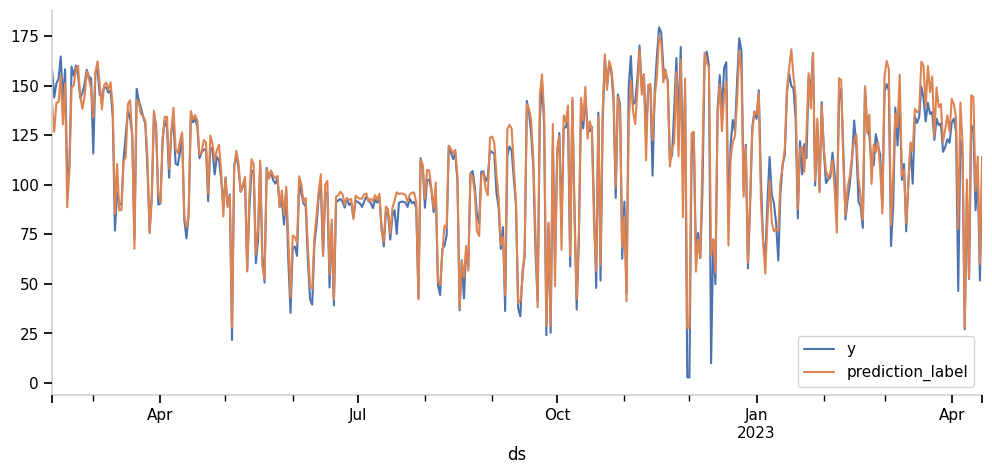

In [ ]:
test[['y', 'prediction_label']].plot(figsize=(12, 5))

In [ ]:
mean_squared_error(test['y'], test['prediction_label'])

60.10851200767869

In [ ]:
mean_squared_error(test['y'], test['prediction_label'], squared=False)

7.752967948320094

In [ ]:
mean_absolute_percentage_error(test['y'], test['prediction_label'])

0.10948764300565364

In [ ]:
r2_score(test['y'], test['prediction_label'])

0.9471046239997589

In [ ]:
teste1 = pd.DataFrame(history.history)
teste1

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,2066.648438,45.438293,12862.649414,113.404533
1,572.058289,23.874292,2876.962646,53.618221
2,471.237915,21.662088,4131.565430,64.262344
3,533.580017,23.056538,4498.436035,67.055923
4,414.769623,20.319277,1139.021973,33.722286
...,...,...,...,...
1995,166.580460,12.484503,172.080246,12.706490
1996,161.479477,12.282713,130.971008,10.970948
1997,171.509552,12.683727,192.313873,13.477009
1998,171.329544,12.676725,258.355011,15.739395


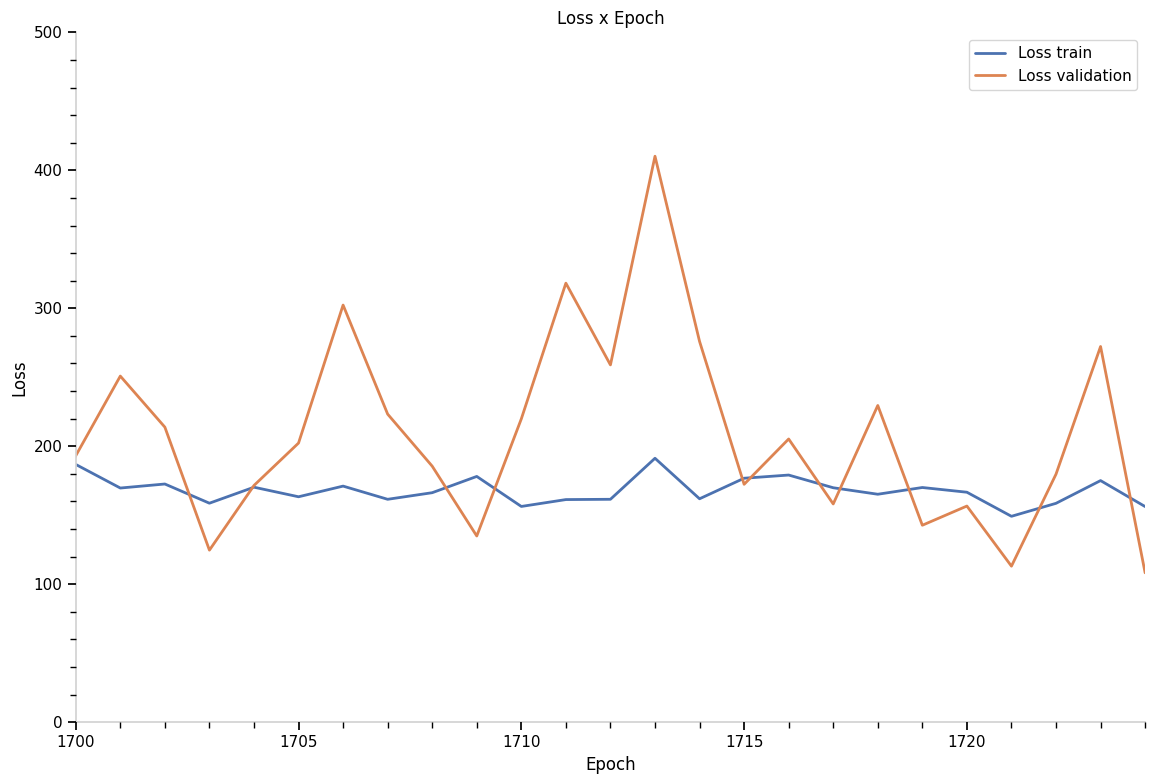

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Loss x Epoch')
plt.plot(np.arange(1, 2000+1, step=1),
         teste1['loss'], linewidth=2, label='Loss train')
plt.plot(np.arange(1, 2000+1, step=1),
         teste1['val_loss'], linewidth=2, label='Loss validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.xticks(np.arange(0, best_epoch+5, step=100))
plt.minorticks_on()
plt.xlim([1700, 1724])
plt.ylim([0, 500])
plt.show()